In [155]:
#import all libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,balanced_accuracy_score,precision_recall_curve, roc_curve
from all_class import *
from sklearn.ensemble import VotingClassifier

In [2]:
#Reading DataFrame of Peanut Maturity
"""
Input: CSV file of Peanut_Maturity having columns,
columns:'Group', 'Number', 'Marure/Immature',Color (M:black, brown/ IM: orange, yellow)
Output: Index: Index of all peanuts specifies (1A, 2A,.....)
        Maturity: Matutre:1, Immature: 0
"""
DataFrame=pd.read_csv('C:/Users/tusha/Downloads/Peanut_Maturity.csv')
New_DataFrame=DataFrame.copy()
Index=DataFrame['Group'][0:-1:15].values
Maturity=New_DataFrame['Marure/Immature'].map({'M':1,'IM':0}).values

In [12]:
#Reading all excel files of peanut reflectance data and create a dataframe having ref of all 225 peanuts
"""
Input: Spectral Files of all peanuts (1A, 1B, 1C,.....)
Output: DataFrame Created for all 225 peanuts and all_columns of the dataframe
"""
path='C:/All/Peanut_Maturity_Classification';
Filename=[os.path.join(path,f'Spectral_{i}_1-15_Side1.csv') for i in Index]
Data1=pd.read_csv(Filename[0])
for i in range(1,len(Filename)):
    Data1=pd.concat([Data1,pd.read_csv(Filename[i])],axis=0)
Data1=Data1.drop(columns=['Unnamed: 0'])

Filename=[os.path.join(path,f'Spectral_{i}_1-15_Side2.csv') for i in Index]
Data2=pd.read_csv(Filename[0])
for i in range(1,len(Filename)):
    Data2=pd.concat([Data2,pd.read_csv(Filename[i])],axis=0)
Data2=Data2.drop(columns=['Unnamed: 0'])

Data=Data1.add(Data2)
All_columns=Data.columns
Final_Data=Data.values/(np.sum(Data,axis=1).values.reshape(-1,1))
Final_Data_Selected=Final_Data[:,205:]

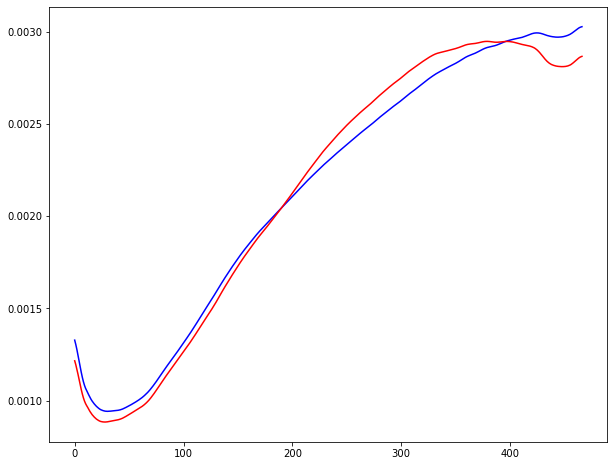

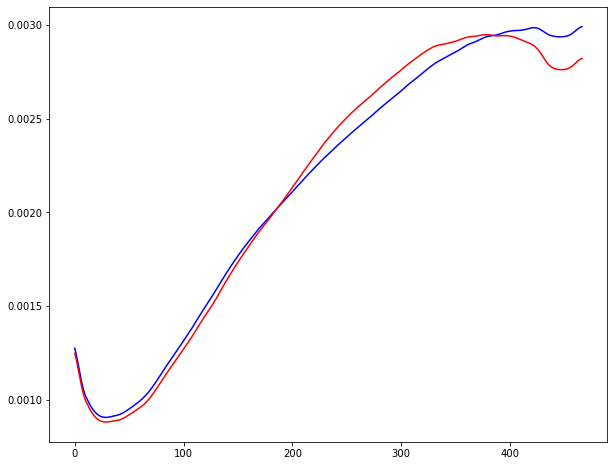

In [4]:
#Graph of 3C and all peanuts
Data_3C=Final_Data[8*15:9*15]
Label_3C=Maturity[8*15:9*15]
Data_3C_M=np.mean(Data_3C[Label_3C==1],axis=0)
Data_3C_IM=np.mean(Data_3C[Label_3C==0],axis=0)
plt.figure(figsize=(10,8))
plt.plot(Data_3C_M,'-b')
plt.plot(Data_3C_IM,'-r')

Data_mature=np.mean(Final_Data[Maturity==1],axis=0)
Data_immature=np.mean(Final_Data[Maturity==0],axis=0)
plt.figure(figsize=(10,8))
plt.plot(Data_mature,'-b')
plt.plot(Data_immature,'-r')

In [18]:
#Data splitting
"""
Spliting the data into training and testing dataset
"""
X_train, X_test, y_train, y_test = train_test_split(Final_Data_Selected, Maturity, test_size=0.30, random_state=1, stratify=Maturity);

In [22]:
#Feature Selection
"""
SBS for feature selection
"""
#stdsc = StandardScaler()
# X_train_std = stdsc.fit_transform(X_train)
# X_test_std = stdsc.fit_transform(X_test)
# lr = LogisticRegression(penalty='l2',max_iter=100,random_state=1,solver='lbfgs',multi_class="auto")
# sbs = SBS(lr, k_features=100,test_size=0.30)
# # sbs.fit(X_train_std, y_train)
# X_train_std_transformed=sbs.transform(X_train_std)
# X_test_std_transformed=sbs.transform(X_test_std)

'\nSBS for feature selection\n'

In [118]:
#Set the model LR model classification
"""
Make a pipline of preprocessing, a grid of parameters for the classifier, fit the model, evaluate the model (Writing into a text file) 
"""
#Make a pipeline containing standard scaling, PCA, estimator
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=100), LogisticRegression());
#making a parameter grid by varing C, random_state and tolerance of logistic regression
parameter_grid_lr=[{'logisticregression__C':[10**i for i in [-2,-1, 0, 1, 2]], 
                    'logisticregression__random_state': list(range(1,50)), 
                    'logisticregression__tol': [10**i for i in [-4,-6,-8]], 
                    'logisticregression__multi_class':['auto'], 
                    'logisticregression__max_iter': [1000], 
                    'logisticregression__class_weight': ['balanced'], 
                    'logisticregression__solver': ['lbfgs']}]
#Creating grid search object and fit in the data
#Cross_validation step can be done in grid search, that is why I avoided manual cross validation
gsr = GridSearchCV(estimator=pipe_lr,param_grid=parameter_grid_lr, scoring='accuracy',cv=10,refit=True,n_jobs=-1)
gsr = gsr.fit(X_train, y_train)

'\nMake a pipline of preprocessing, a grid of parameters for the classifier, fit the model, evaluate the model (Writing into a text file) \n'

In [132]:
y_pred_train=gsr.predict(X_train)
y_pred_test=gsr.predict(X_test)

Train_Confusion_matrix_lr, Test_Confusion_matrix_lr = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_lr, Test_specificity_lr = specificity(Train_Confusion_matrix_lr), specificity(Test_Confusion_matrix_lr)
Train_accuracy_score_lr,Test_accuracy_score_lr = gsr.score(X_train, y_train),gsr.score(X_test, y_test);
Train_precision_score_lr, Test_precision_score_lr=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_lr, Test_recall_score_lr=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_lr, Test_f1_score_lr=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_lr,Test_balanced_accuracy_score_lr=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

file = open("Result_LR.txt", "w")
file.write(f"\nBest parameter for Logistic regression Model is:\n {str(gsr.best_params_)}")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_lr},Test_result: {Test_Confusion_matrix_lr}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_lr},Test_result: {Test_accuracy_score_lr}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_lr},Test_result: {Test_precision_score_lr}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_lr},Test_result: {Test_recall_score_lr}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_lr},Test_result: {Test_f1_score_lr}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_lr},Test_result: {Test_balanced_accuracy_score_lr}")
file.close()

In [168]:
#Set the model SVM model classification
"""
Make a pipline of preprocessing, a grid of parameters for the classifier, fit the model, evaluate the model (Writing into a text file) 
"""
pipe_svm = make_pipeline(StandardScaler(),PCA(n_components=100),svm.SVC());
param_range=[10**i for i in [-2,-1, 0, 1, 2]];
parameter_grid_svm=[{'svc__probability':[True],
                     'svc__C':param_range,
                     'svc__gamma':param_range, 
                     'svc__kernel': ['rbf', 'sigmoid'], 
                     'svc__random_state': list(range(1,50))}]
gss = GridSearchCV(estimator=pipe_svm,param_grid=parameter_grid_svm, scoring='accuracy',cv=10,refit=True,n_jobs=-1)
gss = gss.fit(X_train, y_train)

In [133]:
y_pred_train=gss.predict(X_train)
y_pred_test=gss.predict(X_test)

Train_Confusion_matrix_svm, Test_Confusion_matrix_svm = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_svm, Test_specificity_svm = specificity(Train_Confusion_matrix_svm), specificity(Test_Confusion_matrix_svm)
Train_accuracy_score_svm,Test_accuracy_score_svm = gss.score(X_train, y_train),gss.score(X_test, y_test);
Train_precision_score_svm, Test_precision_score_svm=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_svm, Test_recall_score_svm=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_svm, Test_f1_score_svm=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_svm,Test_balanced_accuracy_score_svm=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

file = open("Result_SVM.txt", "w")
file.write(f"\nBest parameter for Support Vector Machine Model is:\n {str(gsr.best_params_)}")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_svm},Test_result: {Test_Confusion_matrix_svm}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_svm},Test_result: {Test_accuracy_score_svm}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_svm},Test_result: {Test_precision_score_svm}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_svm},Test_result: {Test_recall_score_svm}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_svm},Test_result: {Test_f1_score_svm}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_svm},Test_result: {Test_balanced_accuracy_score_svm}")
file.close()

In [ ]:
#Set the model Random Forest classifier
"""
Make a pipline of preprocessing, a grid of parameters for the classifier, fit the model, evaluate the model (Writing into a text file) 
"""
file = open("Result_RF.txt", "w")
pipe_rf = make_pipeline(StandardScaler(),PCA(n_components=100),RandomForestClassifier());
max_depth = np.arange(10,100,10)
np.append(max_depth,None)
parameter_grid_rf = [{'randomforestclassifier__n_estimators': np.arange(200,1000,100),
               'randomforestclassifier__max_features': ['auto', 'sqrt'],
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': [2, 5, 10],
               'randomforestclassifier__min_samples_leaf': [1, 2, 4],
               'randomforestclassifier__bootstrap': [True, False],
               'randomforestclassifier__random_state': 1}]
grf = GridSearchCV(estimator=pipe_rf,param_grid=parameter_grid_rf, scoring='accuracy',cv=10,refit=True,n_jobs=-1)
grf = grf.fit(X_train, y_train)

In [134]:
y_pred_train=grf.predict(X_train)
y_pred_test=grf.predict(X_test)

Train_Confusion_matrix_rf, Test_Confusion_matrix_rf = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_rf, Test_specificity_rf = specificity(Train_Confusion_matrix_rf), specificity(Test_Confusion_matrix_rf)
Train_accuracy_score_rf,Test_accuracy_score_rf = grf.score(X_train, y_train),grf.score(X_test, y_test);
Train_precision_score_rf, Test_precision_score_rf=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_rf, Test_recall_score_rf=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_rf, Test_f1_score_rf=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_rf,Test_balanced_accuracy_score_rf=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

file = open("Result_RF.txt", "w")
file.write(f"\nBest parameter for Random Forest Model is:\n {str(grf.best_params_)}")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_rf},Test_result: {Test_Confusion_matrix_rf}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_rf},Test_result: {Test_accuracy_score_rf}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_rf},Test_result: {Test_precision_score_rf}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_rf},Test_result: {Test_recall_score_rf}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_rf},Test_result: {Test_f1_score_rf}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_rf},Test_result: {Test_balanced_accuracy_score_rf}")
file.close()

In [185]:
C=gsr.best_params_['logisticregression__C']
class_weight=gsr.best_params_['logisticregression__class_weight'];
max_iter=gsr.best_params_['logisticregression__max_iter']
multi_class=gsr.best_params_['logisticregression__multi_class']
random_state=gsr.best_params_['logisticregression__random_state']
solver=gsr.best_params_['logisticregression__solver']
tol=gsr.best_params_['logisticregression__tol']
Model_LR=LogisticRegression(C = C, class_weight= class_weight, max_iter= max_iter, multi_class=multi_class,random_state=random_state, solver=solver, tol=tol);

C=gss.best_params_['svc__C']
gamma=gss.best_params_['svc__gamma']
kernel=gss.best_params_['svc__kernel']
random_state=gss.best_params_['svc__random_state']
Model_SVM=svm.SVC(probability=True, C=C, gamma=gamma, kernel=kernel, random_state=random_state)

n_estimators=grf.best_params_['randomforestclassifier__n_estimators']
max_depth=grf.best_params_['randomforestclassifier__max_depth']
max_features=grf.best_params_['randomforestclassifier__max_features']
min_samples_split=grf.best_params_['randomforestclassifier__min_samples_split']
min_samples_leaf=grf.best_params_['randomforestclassifier__min_samples_leaf']
bootstrap=grf.best_params_['randomforestclassifier__bootstrap']
Model_RF=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap,
                               random_state=1)

In [186]:
pipeline = make_pipeline(StandardScaler(),PCA(n_components=100))
pipeline=pipeline.fit(X_train)
X_train_pca=pipeline.transform(X_train)
X_test_pca=pipeline.transform(X_test)
ensemble = VotingClassifier(estimators=[('lr', Model_LR), ('svm', Model_SVM), ('rf', Model_RF)], voting='soft')
ensemble = ensemble.fit(X_train_pca, y_train)
ensemble.score(X_train_pca,y_train)
ensemble.score(X_test_pca,y_test)

y_pred_train=ensemble.predict(X_train_pca)
y_pred_test=ensemble.predict(X_test_pca)

Train_Confusion_matrix_en, Test_Confusion_matrix_en = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_en, Test_specificity_en = specificity(Train_Confusion_matrix_en), specificity(Test_Confusion_matrix_en)
Train_accuracy_score_en,Test_accuracy_score_en = ensemble.score(X_train_pca, y_train),ensemble.score(X_test_pca, y_test);
Train_precision_score_en, Test_precision_score_en=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_en, Test_recall_score_en=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_en, Test_f1_score_en=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_en,Test_balanced_accuracy_score_en=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

file = open("Result_ensemble.txt", "w")
file.write(f"\nBest parameter for Random Forest Model is:\n {str(grf.best_params_)}")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_en},Test_result: {Test_Confusion_matrix_en}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_en},Test_result: {Test_accuracy_score_en}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_en},Test_result: {Test_precision_score_en}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_en},Test_result: {Test_recall_score_en}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_en},Test_result: {Test_f1_score_en}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_en},Test_result: {Test_balanced_accuracy_score_en}")
file.close()

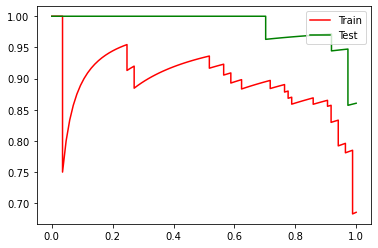

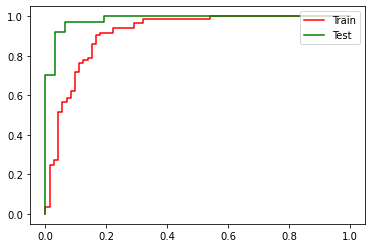

In [177]:
#Plotting ROC_AUC curve and Precision Recall_curve
y_pred_train=gsr.predict_proba(X_train)
y_pred_test=gsr.predict_proba(X_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure()
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.legend(['Train','Test'],loc ="upper right")
plt.figure()
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.legend(['Train','Test'],loc ="upper right")

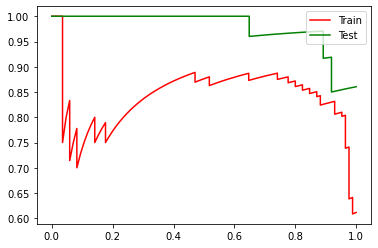

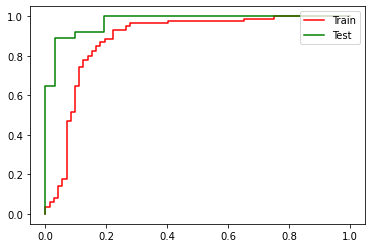

In [178]:
#Plotting ROC_AUC curve and Precision Recall_curve
y_pred_train=gss.predict_proba(X_train)
y_pred_test=gss.predict_proba(X_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure()
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.legend(['Train','Test'],loc ="upper right")
plt.figure()
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.legend(['Train','Test'],loc ="upper right")

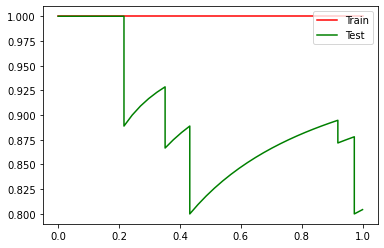

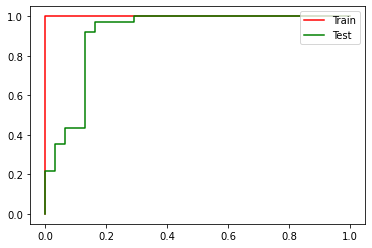

In [179]:
#Plotting ROC_AUC curve and Precision Recall_curve
y_pred_train=grf.predict_proba(X_train)
y_pred_test=grf.predict_proba(X_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure()
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.legend(['Train','Test'],loc ="upper right")
plt.figure()
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.legend(['Train','Test'],loc ="upper right")

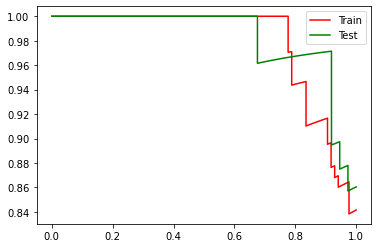

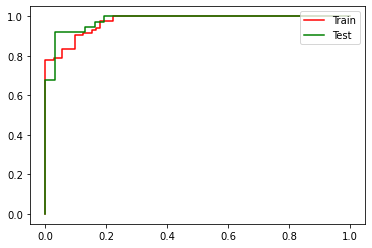

In [188]:
#Plotting ROC_AUC curve and Precision Recall_curve
y_pred_train=ensemble.predict_proba(X_train_pca)
y_pred_test=ensemble.predict_proba(X_test_pca)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure()
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.legend(['Train','Test'],loc ="upper right")
plt.figure()
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.legend(['Train','Test'],loc ="upper right")